In [1]:
import keras
from keras_preprocessing import text
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, Input, Conv1D, MaxPooling1D, LSTM, Dropout
from keras import backend as K
import keras.initializers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import os
import zipfile
import csv,io
import nltk
import string
from string import punctuation
import re
import zipfile
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.


In [2]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Constants

EMBED_SIZE=100
VOCAB_SIZE = 10000
INDEX_FROM = 2
#MAXIMUM_LENGTH = 500
TRAIN_SPLIT = 0.8

In [4]:
# Get Data

!wget http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4c-english.zip

--2019-02-21 00:23:55--  http://alt.qcri.org/semeval2017/task4/data/uploads/codalab/4c-english.zip
Resolving alt.qcri.org (alt.qcri.org)... 13.93.27.76
Connecting to alt.qcri.org (alt.qcri.org)|13.93.27.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1693434 (1.6M) [application/zip]
Saving to: ‘4c-english.zip’

4c-english.zip      100%[===================>]   1.61M  2.58MB/s    in 0.6s    

2019-02-21 00:23:56 (2.58 MB/s) - ‘4c-english.zip’ saved [1693434/1693434]



In [0]:
# Extract Training Data File

def extract_without_folder(arc_name, full_item_name, folder):
    with zipfile.ZipFile(arc_name) as zf:
        file_data = zf.read(full_item_name)
    with open(os.path.join(folder, os.path.basename(full_item_name)), "wb") as fout:
        fout.write(file_data)

path_to_zip_file = '4c-english.zip'
directory_to_extract_to = os.getcwd()  
extract_without_folder(path_to_zip_file,'4C-English/SemEval2017-task4-dev.subtask-CE.english.INPUT.txt',directory_to_extract_to )

In [6]:
#Sanity Check: Read and Display data
text_file = open("SemEval2017-task4-dev.subtask-CE.english.INPUT.txt", "r")
corpus = text_file.read()
print(len(corpus))
print(corpus[:1000])

3048844
681563394940473347	amy schumer	-1	@MargaretsBelly Amy Schumer is the stereotypical 1st world Laci Green feminazi. Plus she's unfunny
675847244747177984	amy schumer	-1	@dani_pitter I mean I get the hype around JLaw. I may not like her but I get her hype. I just don't understand Amy Schumer and her hype
672827854279843840	amy schumer	-1	Amy Schumer at the #GQmenoftheyear2015 party in a dress we pretty much hate: https://t.co/j5HmmyM99j #GQMOTY2015 https://t.co/V8xzmPmPYX
671502639671042048	amy schumer	-1	"Amy Schumer may have brought us Trainwreck, but that word just got redefined on #TheVoice."
677359143108214784	amy schumer	-1	I just think that sports are stupid &amp;anyone who likes them is a lesser person &amp; has a small intellect- Amy Schumer https://t.co/fdjWKKG5AR
663714752162607104	amy schumer	-1	"If you do like Amy Schumer, I hope you went &amp; saw her Saturday bc after this ridiculousness, I highly doubt Maine will be on list of faves."
671468325617033216	amy schumer

In [0]:
#Preprocessing 1 - Create tweet data and labels

labels = []
targets = []
tweets = []
f = csv.reader(io.StringIO(corpus), delimiter='\t')
for row in f:
  targets.append(row[1])
  labels.append(row[2])
  tweets.append(row[3])



In [8]:
#Sanity Check
print(targets[0])
print(labels[0])
print(tweets[0])

amy schumer
-1
@MargaretsBelly Amy Schumer is the stereotypical 1st world Laci Green feminazi. Plus she's unfunny


In [0]:
remove_terms = punctuation + '0123456789'

In [0]:
def normalize_document(doc):
    stop_words = nltk.corpus.stopwords.words('english')
    wpt = nltk.WordPunctTokenizer()


    # lower case and remove special characters\whitespaces

    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)

    doc = doc.lower()

    doc = doc.strip()

    # tokenize document

    tokens = wpt.tokenize(doc)

    # filter stopwords out of document

    filtered_tokens = [token for token in tokens if token not in stop_words]

    # re-create document from filtered tokens

    doc = ' '.join(filtered_tokens)

    return doc
 

In [0]:
normalize_corpus = np.vectorize(normalize_document)
normalized_corpus = [[word.lower() for word in sent if word not in remove_terms] for sent in tweets]

normalized_corpus = [''.join(tok_sent) for tok_sent in normalized_corpus]

#normalized_corpus = filter(None, normalize_corpus(normalized_corpus))
#normalized_corpus = list(normalized_corpus)
#normalized_corpus = [tok_sent for tok_sent in normalized_corpus if len(tok_sent.split()) > 2]

normalized_corpus = list(normalized_corpus)

In [12]:
print(tweets[0])
print(normalized_corpus[0])

@MargaretsBelly Amy Schumer is the stereotypical 1st world Laci Green feminazi. Plus she's unfunny
margaretsbelly amy schumer is the stereotypical st world laci green feminazi plus shes unfunny


In [13]:
#  Apply Target Masking to make the problem one of text classification

target_mask = '*TARGET*'
normalized_tweets = []
for i in range(len(tweets)):
  new_tweet = normalized_corpus[i].replace(targets[i],target_mask)
  normalized_tweets.append(new_tweet)

normalized_corpus = normalized_tweets #To reuse earlier code

print(len(normalized_tweets))
print(tweets[1500])
print(normalized_corpus[1500])

20632
That brawl between undertaker and Brock Lesnar was crazy last Monday on Raw I want to see more
that brawl between undertaker and *TARGET* was crazy last monday on raw i want to see more


In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(nb_words=VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_corpus)
sequences = tokenizer.texts_to_sequences(normalized_corpus)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 36721 unique tokens.


In [0]:
def lengths(x):
    if isinstance(x,list):
        yield len(x)
        for y in x:
            yield from lengths(y)

MAXIMUM_LENGTH = max([len(x) for x in normalized_corpus])

In [16]:
from keras.utils import to_categorical

data = pad_sequences(sequences, maxlen=MAXIMUM_LENGTH)

#labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
#print('Shape of label tensor:', labels.shape)

Shape of data tensor: (20632, 154)


In [0]:
print(data[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    1   10    2 7843   33  152 1221  968  393]


In [0]:
os.listdir()

['.config',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt',
 'cc.ar.300.vec.gz',
 'SemEval2017-task4-dev.subtask-A.english.INPUT.txt',
 'SemEval2017-task4-dev.subtask-A.arabic.INPUT.txt',
 '4c-english.zip.1',
 'SemEval2017-task4-dev.subtask-CE.english.INPUT.txt',
 'glove.6B.50d.txt',
 '4a-english.zip',
 'glove.6B.zip',
 'glove.6B.100d.txt',
 'cc.ar.300.vec',
 '4a-arabic.zip',
 '4c-english.zip',
 'sample_data']

In [0]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
data = data[indices]
#targets = targets[indices]
#labels = labels[indices]



In [0]:


nb_validation_samples = int(TRAIN_SPLIT * data.shape[0])

x_val = data[:-nb_validation_samples]
y_val = labels[:-nb_validation_samples]
x_train = data[-nb_validation_samples:]
y_train = labels[-nb_validation_samples:]

#y_train2 = targets[:-nb_validation_samples]
#y_val2 = targets[-nb_validation_samples:]

In [0]:
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

#y_train2 = encoder.transform(y_train2)
#y_val2 = encoder.transform(y_val2)

In [21]:
# Get Pre-trained Embeddings

!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-02-21 00:26:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-02-21 00:26:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  40.3MB/s    in 24s     

2019-02-21 00:26:29 (34.3 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [0]:
#Unzip the embedding files

path_to_zip_file = 'glove.6B.zip'
directory_to_extract_to = os.getcwd()  

zip_ref = zipfile.ZipFile(path_to_zip_file, 'r')
zip_ref.extractall(directory_to_extract_to)
zip_ref.close()

In [23]:
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAXIMUM_LENGTH,
                            trainable=False)

In [0]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [27]:
# Model with Embedding Layer
model = Sequential()

#We change our first layer in model1 to an Embedding layer
model.add(keras.layers.Embedding(VOCAB_SIZE,16))


#The second layer is to compute average on all word vectors 
model.add(GlobalAveragePooling1DMasked())



#The output vector is piped through a fully-connected layer
model.add(keras.layers.Dense(16, activation=K.relu))



#The last layer is connected with a single output node with the sigmoid activation function
model.add(keras.layers.Dense(5, activation=K.softmax))


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_mas (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 160,357
Trainable params: 160,357
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(x_train,
                    np.array(y_train),
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, np.array(y_val)),
                    verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 16505 samples, validate on 4127 samples
Epoch 1/3
16505/16505 [==============================] - 1s 82us/step - loss: 1.2972 - acc: 0.4922 - val_loss: 1.1824 - val_acc: 0.4723
Epoch 2/3
16505/16505 [==============================] - 1s 69us/step - loss: 1.0681 - acc: 0.4927 - val_loss: 1.1207 - val_acc: 0.4723
Epoch 3/3
16505/16505 [==============================] - 1s 69us/step - loss: 1.0487 - acc: 0.4927 - val_loss: 1.1139 - val_acc: 0.4723


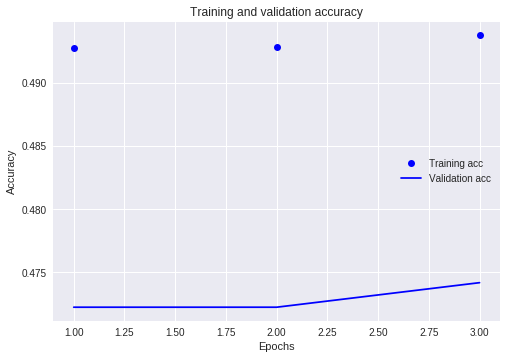

In [0]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#print(x_train[0])
#print(y_train[0])
print(x_val[0])
print(y_val[0])

In [29]:
model_lstm = Sequential() 

model_lstm.add(embedding_layer)

#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm.add(LSTM(100)) 
model_lstm.add(Dense(5, activation='softmax')) 
model_lstm.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_mas (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 160,357
Trainable params: 160,357
Non-trainable params: 0
_________________________________________________________________


In [30]:
history_lstm = model_lstm.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)


Train on 16505 samples, validate on 4127 samples
Epoch 1/3
16505/16505 [==============================] - 75s 5ms/step - loss: 0.9759 - acc: 0.5664 - val_loss: 1.0335 - val_acc: 0.5350
Epoch 2/3
16505/16505 [==============================] - 75s 5ms/step - loss: 0.8952 - acc: 0.6001 - val_loss: 0.9616 - val_acc: 0.5592
Epoch 3/3
16505/16505 [==============================] - 74s 5ms/step - loss: 0.8693 - acc: 0.6111 - val_loss: 0.9649 - val_acc: 0.5602


In [31]:
results_lstm = model_lstm.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm[0], 'Test Accuracy: ',results_lstm[1])

4127/4127 [==============================] - 5s 1ms/step
Test Loss:  0.9648769575139354 Test Accuracy:  0.5602132298841238


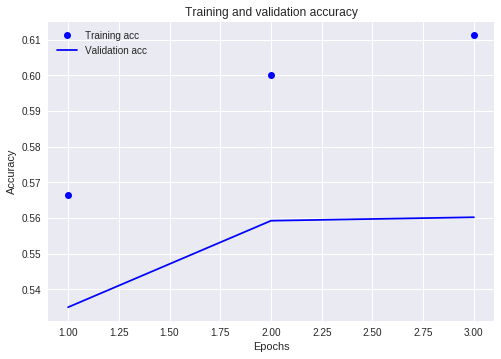

In [32]:
import matplotlib.pyplot as plt

history_dict_lstm = history_lstm.history

acc = history_dict_lstm['acc']
val_acc = history_dict_lstm['val_acc']
loss = history_dict_lstm['loss']
val_loss = history_dict_lstm['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
history_lstm_6 = model_lstm.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)


Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 74s 5ms/step - loss: 0.8443 - acc: 0.6239 - val_loss: 0.9552 - val_acc: 0.5646
Epoch 2/6
16505/16505 [==============================] - 73s 4ms/step - loss: 0.8203 - acc: 0.6334 - val_loss: 0.9339 - val_acc: 0.5721
Epoch 3/6
16505/16505 [==============================] - 73s 4ms/step - loss: 0.8025 - acc: 0.6447 - val_loss: 0.9789 - val_acc: 0.5643
Epoch 4/6
16505/16505 [==============================] - 73s 4ms/step - loss: 0.7848 - acc: 0.6511 - val_loss: 0.9836 - val_acc: 0.5658
Epoch 5/6
16505/16505 [==============================] - 73s 4ms/step - loss: 0.7628 - acc: 0.6623 - val_loss: 0.9526 - val_acc: 0.5752
Epoch 6/6
16505/16505 [==============================] - 73s 4ms/step - loss: 0.7418 - acc: 0.6745 - val_loss: 0.9991 - val_acc: 0.5701


In [34]:
results_lstm_6 = model_lstm.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm[0], 'Test Accuracy: ',results_lstm[1])

4127/4127 [==============================] - 5s 1ms/step
Test Loss:  0.9648769575139354 Test Accuracy:  0.5602132298841238


In [0]:
model_lstm2 = Sequential() 

model_lstm2.add(embedding_layer)
model_lstm2.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm2.add(LSTM(100)) 
model_lstm2.add(Dropout(0.5))
model_lstm2.add(Dense(5, activation='softmax')) 
model_lstm2.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 154, 100)          3672200   
_________________________________________________________________
dropout_9 (Dropout)          (None, 154, 100)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 505       
Total params: 3,753,105
Trainable params: 80,905
Non-trainable params: 3,672,200
_________________________________________________________________


In [0]:
history_lstm2 = model_lstm2.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/3
16505/16505 [==============================] - 77s 5ms/step - loss: 1.0541 - acc: 0.5174 - val_loss: 1.0158 - val_acc: 0.5241
Epoch 2/3
16505/16505 [==============================] - 74s 4ms/step - loss: 0.9786 - acc: 0.5581 - val_loss: 0.9888 - val_acc: 0.5440
Epoch 3/3
16505/16505 [==============================] - 75s 5ms/step - loss: 0.9562 - acc: 0.5686 - val_loss: 0.9738 - val_acc: 0.5459


In [0]:
results_lstm2 = model_lstm2.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm2[0], 'Test Accuracy: ',results_lstm2[1])

4127/4127 [==============================] - 5s 1ms/step
Test Loss:  0.9738151708670613 Test Accuracy:  0.5459171309796378


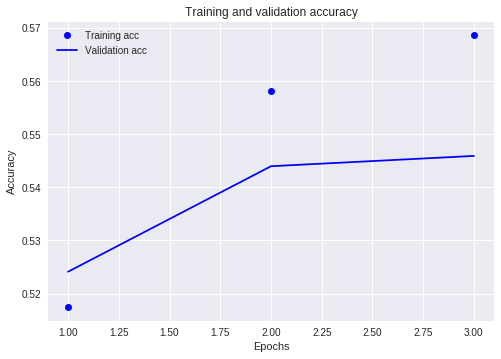

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm2 = history_lstm2.history

acc = history_dict_lstm2['acc']
val_acc = history_dict_lstm2['val_acc']
loss = history_dict_lstm2['loss']
val_loss = history_dict_lstm2['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm3 = Sequential() 

model_lstm3.add(embedding_layer)
model_lstm3.add(Dropout(0.5))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm3.add(LSTM(100)) 
model_lstm3.add(Dropout(0.5))
model_lstm3.add(Dense(5, activation='softmax')) 
model_lstm3.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 154, 100)          3672200   
_________________________________________________________________
dropout_11 (Dropout)         (None, 154, 100)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 505       
Total params: 3,753,105
Trainable params: 80,905
Non-trainable params: 3,672,200
_________________________________________________________________


In [0]:
history_lstm3 = model_lstm3.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 79s 5ms/step - loss: 1.0611 - acc: 0.5094 - val_loss: 1.0885 - val_acc: 0.5025
Epoch 2/6
16505/16505 [==============================] - 75s 5ms/step - loss: 0.9744 - acc: 0.5586 - val_loss: 0.9898 - val_acc: 0.5374
Epoch 3/6
16505/16505 [==============================] - 76s 5ms/step - loss: 0.9482 - acc: 0.5739 - val_loss: 0.9768 - val_acc: 0.5413
Epoch 4/6
16505/16505 [==============================] - 75s 5ms/step - loss: 0.9277 - acc: 0.5904 - val_loss: 0.9596 - val_acc: 0.5476
Epoch 5/6
16505/16505 [==============================] - 76s 5ms/step - loss: 0.9188 - acc: 0.5862 - val_loss: 0.9925 - val_acc: 0.5326
Epoch 6/6
16505/16505 [==============================] - 75s 5ms/step - loss: 0.9103 - acc: 0.5912 - val_loss: 0.9415 - val_acc: 0.5602


In [0]:
results_lstm3 = model_lstm3.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm3[0], 'Test Accuracy: ',results_lstm3[1])

4127/4127 [==============================] - 5s 1ms/step
Test Loss:  0.941548328134492 Test Accuracy:  0.5602132298913451


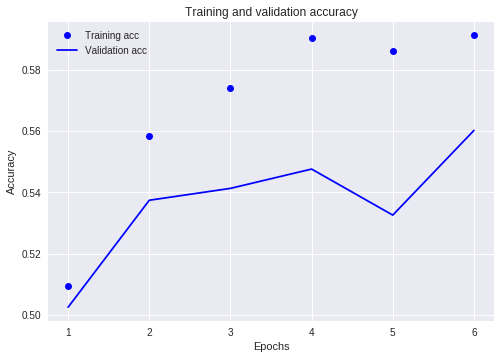

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm3 = history_lstm3.history

acc = history_dict_lstm3['acc']
val_acc = history_dict_lstm3['val_acc']
loss = history_dict_lstm3['loss']
val_loss = history_dict_lstm3['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
model_lstm4 = Sequential() 

model_lstm4.add(embedding_layer)
model_lstm4.add(Dropout(0.3))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm4.add(LSTM(100)) 
model_lstm4.add(Dropout(0.3))
model_lstm4.add(Dense(5, activation='softmax')) 
model_lstm4.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 154, 100)          3672200   
_________________________________________________________________
dropout_13 (Dropout)         (None, 154, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 505       
Total params: 3,753,105
Trainable params: 80,905
Non-trainable params: 3,672,200
_________________________________________________________________


In [0]:
history_lstm4 = model_lstm4.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=100,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 79s 5ms/step - loss: 1.0350 - acc: 0.5263 - val_loss: 1.0286 - val_acc: 0.5161
Epoch 2/6
16505/16505 [==============================] - 76s 5ms/step - loss: 0.9434 - acc: 0.5762 - val_loss: 0.9658 - val_acc: 0.5512
Epoch 3/6
16505/16505 [==============================] - 75s 5ms/step - loss: 0.9152 - acc: 0.5901 - val_loss: 0.9701 - val_acc: 0.5459
Epoch 4/6
16505/16505 [==============================] - 76s 5ms/step - loss: 0.8955 - acc: 0.5974 - val_loss: 0.9565 - val_acc: 0.5583
Epoch 5/6
16505/16505 [==============================] - 76s 5ms/step - loss: 0.8780 - acc: 0.6039 - val_loss: 0.9469 - val_acc: 0.5583
Epoch 6/6
16505/16505 [==============================] - 76s 5ms/step - loss: 0.8684 - acc: 0.6090 - val_loss: 0.9476 - val_acc: 0.5694


In [0]:
results_lstm4 = model_lstm4.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm4[0], 'Test Accuracy: ',results_lstm4[1])

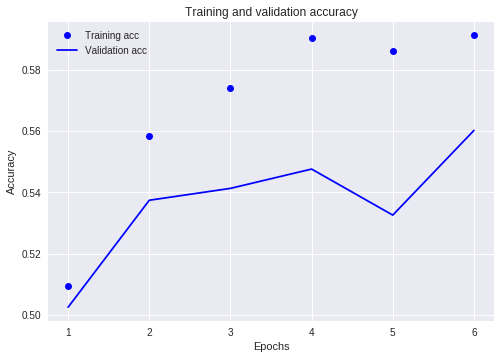

In [0]:
import matplotlib.pyplot as plt

history_dict_lstm4 = history_lstm4.history

acc = history_dict_lstm4['acc']
val_acc = history_dict_lstm4['val_acc']
loss = history_dict_lstm4['loss']
val_loss = history_dict_lstm4['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [36]:
model_lstm5 = Sequential() 

model_lstm5.add(embedding_layer)
model_lstm5.add(Dropout(0.3))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm5.add(LSTM(100)) 
model_lstm5.add(Dropout(0.3))
model_lstm5.add(Dense(5, activation='softmax')) 
model_lstm5.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm5.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 154, 100)          3672200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 154, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 505       
Total params: 3,753,105
Trainable params: 80,905
Non-trainable params: 3,672,200
_________________________________________________________________


In [37]:
history_lstm5 = model_lstm5.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 88s 5ms/step - loss: 1.0040 - acc: 0.5370 - val_loss: 0.9922 - val_acc: 0.5413
Epoch 2/6
16505/16505 [==============================] - 87s 5ms/step - loss: 0.9198 - acc: 0.5885 - val_loss: 0.9596 - val_acc: 0.5486
Epoch 3/6
16505/16505 [==============================] - 88s 5ms/step - loss: 0.8934 - acc: 0.5967 - val_loss: 0.9506 - val_acc: 0.5653
Epoch 4/6
16505/16505 [==============================] - 86s 5ms/step - loss: 0.8731 - acc: 0.6087 - val_loss: 0.9354 - val_acc: 0.5704
Epoch 5/6
16505/16505 [==============================] - 87s 5ms/step - loss: 0.8583 - acc: 0.6130 - val_loss: 0.9375 - val_acc: 0.5735
Epoch 6/6
16505/16505 [==============================] - 87s 5ms/step - loss: 0.8453 - acc: 0.6225 - val_loss: 0.9201 - val_acc: 0.5823


In [39]:
results_lstm5 = model_lstm5.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm5[0], 'Test Accuracy: ',results_lstm5[1])

4127/4127 [==============================] - 5s 1ms/step
Test Loss:  0.9200697241986032 Test Accuracy:  0.5822631450695364


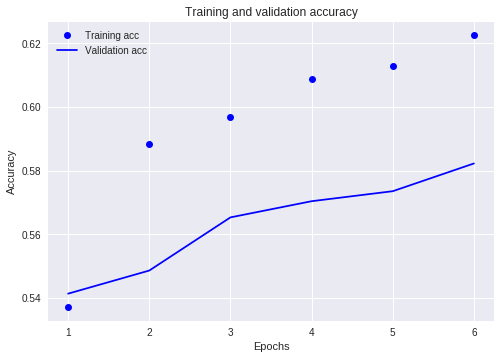

In [42]:
import matplotlib.pyplot as plt

history_dict_lstm5 = history_lstm5.history

acc = history_dict_lstm5['acc']
val_acc = history_dict_lstm5['val_acc']
loss = history_dict_lstm5['loss']
val_loss = history_dict_lstm5['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [38]:
model_lstm6 = Sequential() 

model_lstm6.add(embedding_layer)
model_lstm6.add(Dropout(0.3))
#model_lstm.add(GlobalAveragePooling1DMasked())

model_lstm6.add(LSTM(100)) 
model_lstm6.add(Dropout(0.3))
model_lstm6.add(Dense(5, activation='softmax')) 
model_lstm6.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) 

model_lstm6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 154, 100)          3672200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 154, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 3,753,105
Trainable params: 80,905
Non-trainable params: 3,672,200
_________________________________________________________________


In [40]:
history_lstm6 = model_lstm6.fit(x_train,
                    y_train,
                    epochs=6,
                    batch_size=16,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 16505 samples, validate on 4127 samples
Epoch 1/6
16505/16505 [==============================] - 142s 9ms/step - loss: 0.9822 - acc: 0.5524 - val_loss: 0.9809 - val_acc: 0.5498
Epoch 2/6
16505/16505 [==============================] - 141s 9ms/step - loss: 0.9149 - acc: 0.5890 - val_loss: 0.9613 - val_acc: 0.5602
Epoch 3/6
16505/16505 [==============================] - 138s 8ms/step - loss: 0.8886 - acc: 0.5999 - val_loss: 0.9398 - val_acc: 0.5638
Epoch 4/6
16505/16505 [==============================] - 139s 8ms/step - loss: 0.8655 - acc: 0.6101 - val_loss: 0.9257 - val_acc: 0.5774
Epoch 5/6
16505/16505 [==============================] - 139s 8ms/step - loss: 0.8481 - acc: 0.6204 - val_loss: 0.9412 - val_acc: 0.5750
Epoch 6/6
16505/16505 [==============================] - 140s 9ms/step - loss: 0.8314 - acc: 0.6250 - val_loss: 0.9238 - val_acc: 0.5837


In [41]:
results_lstm6 = model_lstm6.evaluate(x_val,y_val)
print('Test Loss: ', results_lstm6[0], 'Test Accuracy: ',results_lstm6[1])

4127/4127 [==============================] - 4s 1ms/step
Test Loss:  0.9237843861526747 Test Accuracy:  0.5837169856172455


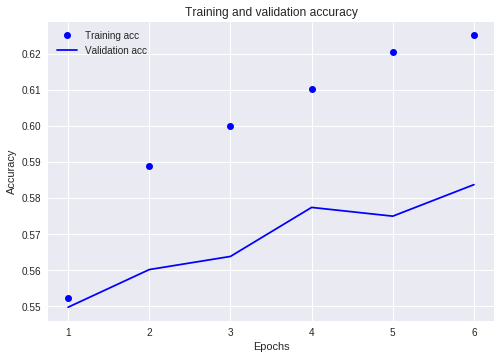

In [43]:
import matplotlib.pyplot as plt

history_dict_lstm6 = history_lstm6.history

acc = history_dict_lstm6['acc']
val_acc = history_dict_lstm6['val_acc']
loss = history_dict_lstm6['loss']
val_loss = history_dict_lstm6['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [44]:
os.listdir()

['.config',
 'glove.6B.50d.txt',
 'SemEval2017-task4-dev.subtask-A.arabic.INPUT.txt',
 'cc.ar.300.vec.gz',
 'SemEval2017-task4-dev.subtask-CE.english.INPUT.txt',
 'SemEval2017-task4-test.subtask-A.arabic.txt',
 '4a-arabic.zip',
 'glove.6B.300d.txt',
 'cc.ar.300.vec',
 'glove.6B.zip',
 '4c-english.zip',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'sample_data']

In [47]:
text_file = open("SemEval2017-task4-test.subtask-CE.english.txt", "r")
test_corpus = text_file.read()
print(len(test_corpus))
print(test_corpus[:1000])

747542
55040	grayson allen	2	Grayson Allen is so cute 😭😭😭
801608340082162944	grayson allen	0	#FrankJackson Grayson Allen & Frank Jackson Duke Full Highlights 11.15.16. vs Kansas - 23 … https://t.co/TQrtLTobuG https://t.co/SF1DuAnL6c
801608486736034944	grayson allen	0	Frank Jackson led the Blue Devils with 19 points along with Grayson Allen who also put up 17 on the board. #Duke
801609588449693056	grayson allen	0	Grayson Allen passed Antonio Lang & Andre Dawkins into 62nd #DukeScoringList
801610715350055936	grayson allen	1	@BrocKuerzi they went down to the last play against Kansas without 2 or 3 of their starters and Grayson Allen is winning POY
801611617783992064	grayson allen	1	@BrocKuerzi lol Grayson Allen would outscore every guard on UK's team
801612735385661056	grayson allen	0	@brendan_gacek Grayson Allen is a Dwayne wade James harden hybrid
801617001965874944	grayson allen	-1	@cagle_erin @katiehindersman Katie, don't worry about the Duke/Grayson Allen talk. He will trip people al

In [50]:
labels = []
targets = []
test_tweets = []
f = csv.reader(io.StringIO(test_corpus), delimiter='\t')
for row in f:
  targets.append(row[1])
  labels.append(row[2])
  test_tweets.append(row[3])


normalize_corpus = np.vectorize(normalize_document)
normalized_corpus = [[word.lower() for word in sent if word not in remove_terms] for sent in test_tweets]

normalized_corpus = [''.join(tok_sent) for tok_sent in normalized_corpus]

#normalized_corpus = filter(None, normalize_corpus(normalized_corpus))
#normalized_corpus = list(normalized_corpus)
#normalized_corpus = [tok_sent for tok_sent in normalized_corpus if len(tok_sent.split()) > 2]

normalized_corpus = list(normalized_corpus)


target_mask = '*TARGET*'
normalized_tweets = []
for i in range(len(tweets)):
  new_tweet = normalized_corpus[i].replace(targets[i],target_mask)
  normalized_tweets.append(new_tweet)

normalized_corpus = normalized_tweets #To reuse earlier code


tokenizer = Tokenizer(nb_words=VOCAB_SIZE)
tokenizer.fit_on_texts(normalized_corpus)
sequences = tokenizer.texts_to_sequences(normalized_corpus)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


data = pad_sequences(sequences, maxlen=MAXIMUM_LENGTH)

print('Shape of data tensor:', data.shape)


# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)
data = data[indices]

nb_validation_samples = int(TRAIN_SPLIT * data.shape[0])

x_val = data[:-nb_validation_samples]
y_val = labels[:-nb_validation_samples]
x_train = data[-nb_validation_samples:]
y_train = labels[-nb_validation_samples:]

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 17367 unique tokens.
Shape of data tensor: (4951, 154)
